# Parking Analysis
Main goal of this notebook: Analyze the occupancy of parking lots for the autofrei policy. Therefore, do the following analyses:
1. Analyze the maximum parking occupancy per link
2. Analyze the hourly parking occupancy per link

For both analyses, visualize the results on a map. The corresponding event handler (ParkingAnalyzer) outputs a CSV file which is read here.

In [ ]:
import pandas
from geopandas import GeoDataFrame
# Config notebook for retina displays
%config InlineBackend.figure_format = 'retina'

import matsim
import pandas as pd

In [ ]:
CAR_LENGTH = 7.5
PCT = 10

base_df = pd.read_csv("../../../../output/berlin-autofrei-v6.4-baseCaseCtd/parking_occupancy_autofrei.csv")

policy_df = pd.read_csv("../../../../output/berlin-autofrei-v6.4-policy/parking_occupancy_autofrei.csv")
policy_df

In [ ]:
# load network
network = matsim.read_network("../../../../output/berlin-autofrei-v6.4-policy/berlin-v6.4.output_network.xml.gz")
geo = network.as_geo()

geo["spots_supply"] = geo["length"] / CAR_LENGTH / PCT  # integer division or not? especially for small links relevant

In [ ]:
def merge_df_with_geo(parking_data: pandas.DataFrame) -> GeoDataFrame:
    merged = geo.merge(
        parking_data[['linkId', 'from_time', 'to_time', 'occupancy', 'initial']],
        left_on='link_id',
        right_on='linkId',
        how='left'
    ).drop(columns='linkId')

    merged["relative_occupancy"] = merged["occupancy"] / merged["spots_supply"]
    return merged


# merge geo with df based on geo.link_id and df.linkId. Take all columns from geo and from_time, to_time, occupancy, initial, spots_supply, relative_occupancy from df
base_merged = merge_df_with_geo(base_df)
policy_merged = merge_df_with_geo(policy_df)

policy_merged

In [ ]:
# plot in seaborn length vs. relative_occupancy
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, (data, case) in zip(axes, [(base_merged, "Base"), (policy_merged, "Policy")]):
    sns.scatterplot(data=data, x="length", y="relative_occupancy", ax=ax)
    ax.axhline(y=1, color='r', linestyle='--')
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Link Length (m)")
    ax.set_ylabel("Relative Parking Occupancy")
    ax.set_title(case + ": Parking Occupancy vs. Link Length")

plt.tight_layout()
plt.show()

Results: There is a clear trend that shorter links have a higher relative occupancy. The red line depicts the 100% occupancy threshold.

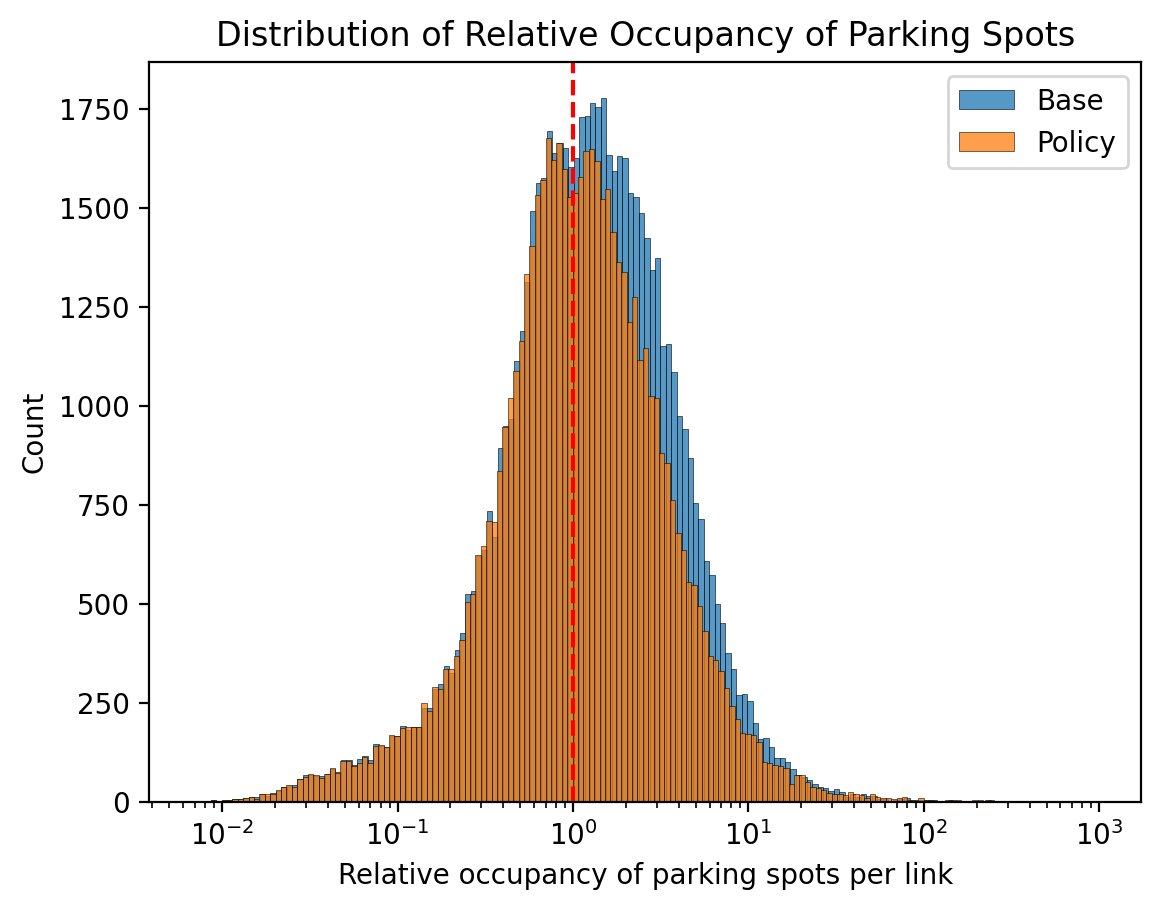

In [34]:
sns.histplot(base_merged, log_scale=True, x="relative_occupancy", label="Base")
sns.histplot(policy_merged, log_scale=True, x="relative_occupancy", label="Policy")
# add vertical line at x=1
plt.axvline(x=1, color='red', linestyle='--')
# add x label: Relative occupancy of parking spots per link
plt.xlabel("Relative occupancy of parking spots per link")
# add title: Distribution of Relative Occupancy of parking spots
plt.title("Distribution of Relative Occupancy of Parking Spots")
plt.legend()

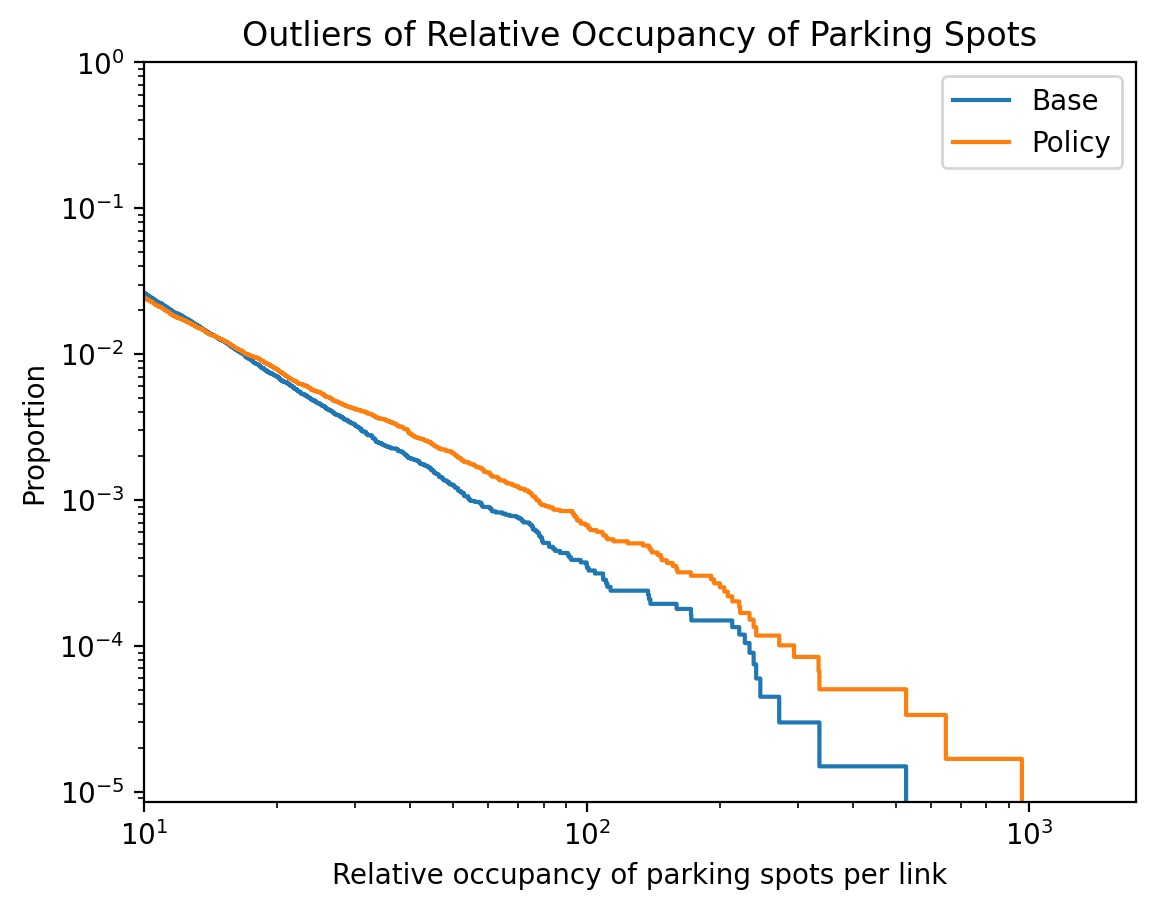

In [35]:
sns.ecdfplot(base_merged, x="relative_occupancy", label="Base", complementary=True)
sns.ecdfplot(policy_merged, x="relative_occupancy", label="Policy", complementary=True)
plt.xscale('log')
plt.yscale('log')

plt.title("Outliers of Relative Occupancy of Parking Spots")
plt.xlabel("Relative occupancy of parking spots per link")

plt.xlim(10, None)
plt.legend()

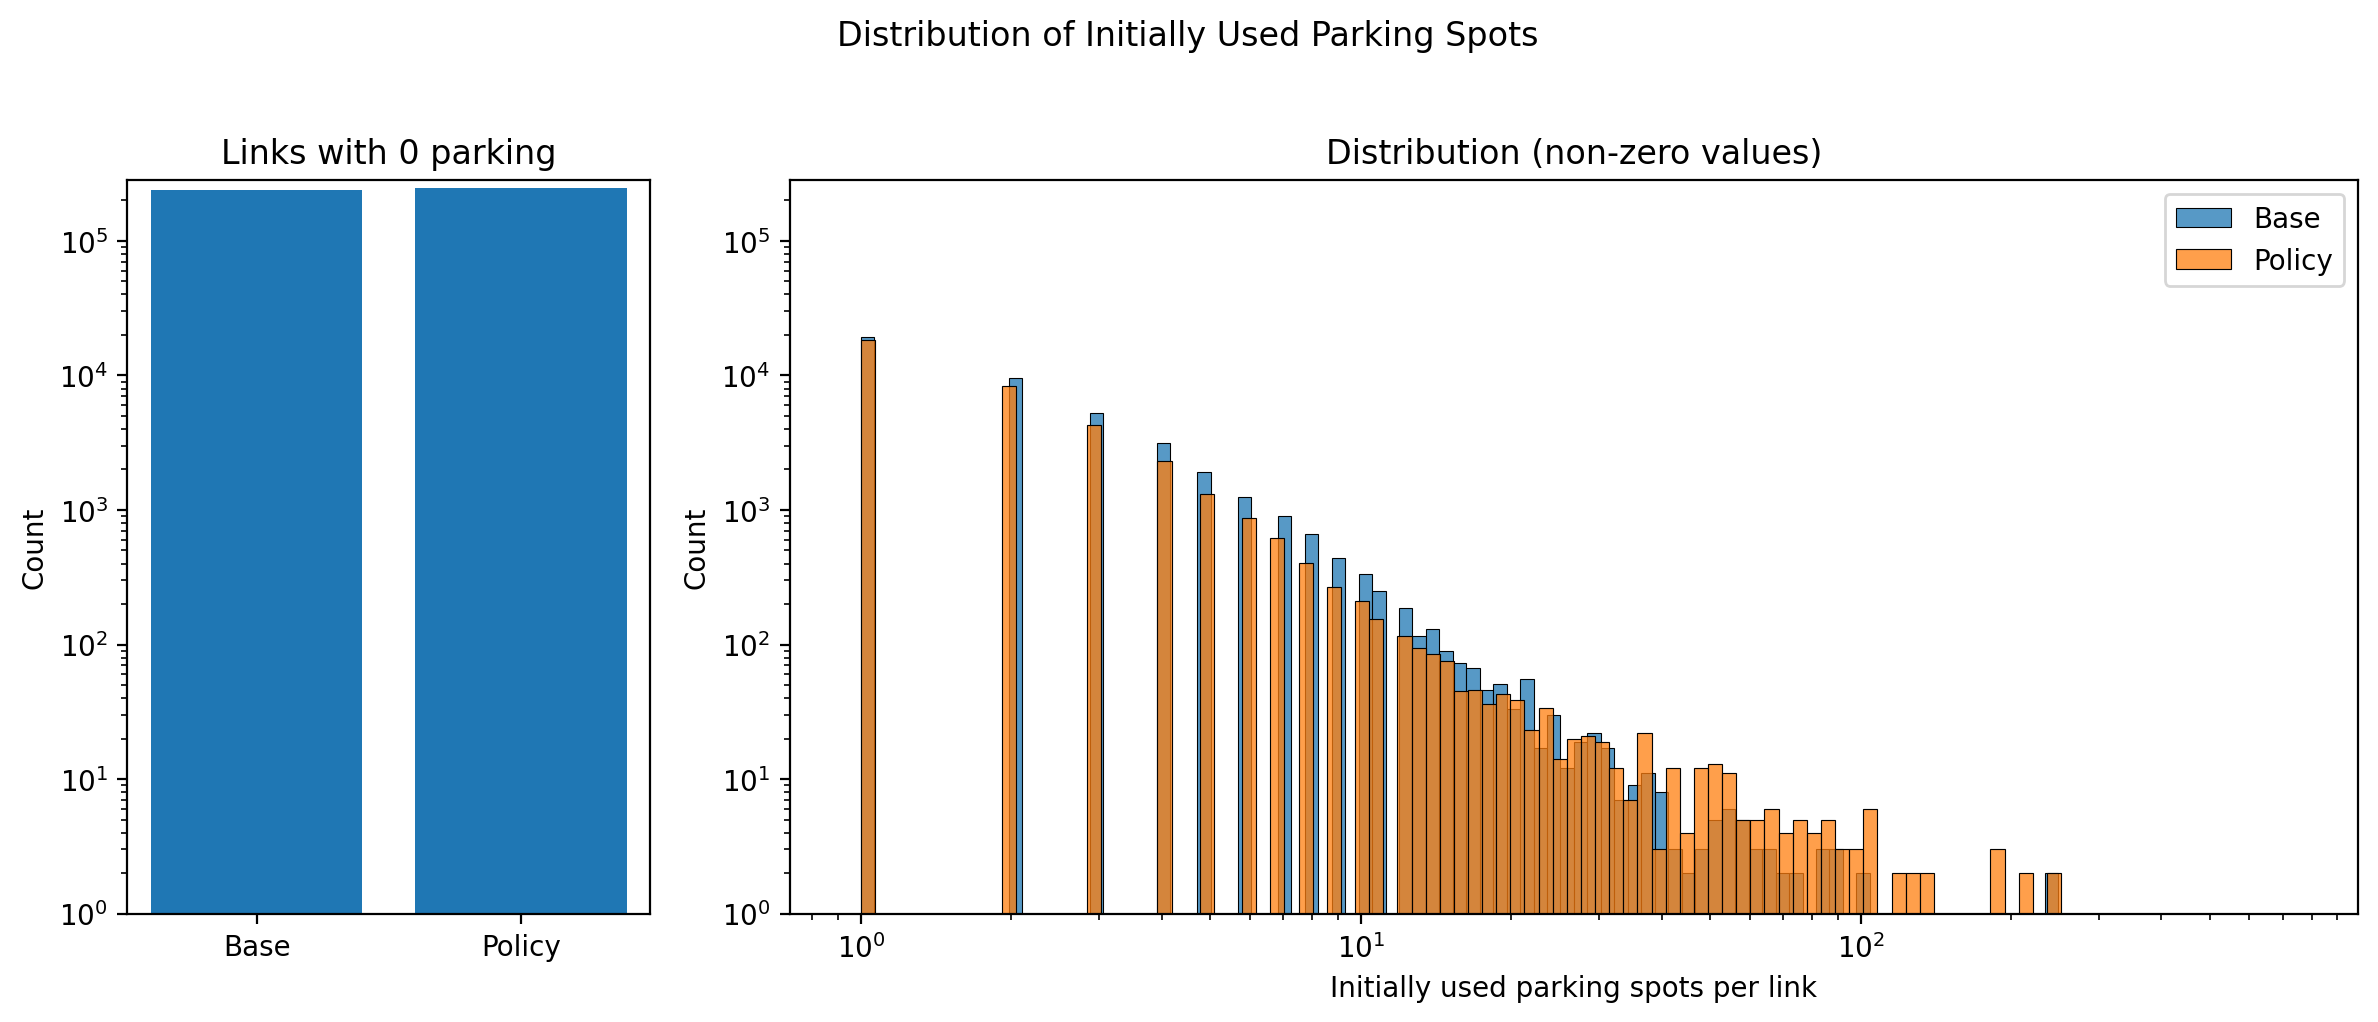

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 3]})

# Left: count of zeros
zero_counts = [
    (base_merged.fillna(0)["initial"] == 0).sum(),
    (policy_merged.fillna(0)["initial"] == 0).sum()
]
axes[0].bar(["Base", "Policy"], zero_counts)
axes[0].set_title("Links with 0 parking")
axes[0].set_ylabel("Count")

# Right: log-scale histogram for non-zero values
sns.histplot(base_merged[base_merged["initial"] > 0], log_scale=True, x="initial", label="Base", ax=axes[1])
sns.histplot(policy_merged[policy_merged["initial"] > 0], log_scale=True, x="initial", label="Policy", ax=axes[1])
axes[1].set_title("Distribution (non-zero values)")
axes[1].set_xlabel("Initially used parking spots per link")
axes[1].legend()

# Set log scale for y-axis and synchronize
max_y = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(1, max_y * 1.1)

plt.suptitle("Distribution of Initially Used Parking Spots", y=1.02)
plt.tight_layout()

Here, I am starting to play around with geopandas and interactive maps.

In [ ]:
import geopandas as gpd

# Convert your DataFrame to a GeoDataFrame
gdf_base = gpd.GeoDataFrame(base_merged, geometry='geometry')
gdf_base = gdf_base.set_crs(epsg=25832)  # Adjust EPSG code based on your data

gdf_policy = gpd.GeoDataFrame(policy_merged, geometry='geometry')
gdf_policy = gdf_policy.set_crs(epsg=25832)  # Adjust EPSG code based on your data

In [ ]:
# from keplergl import KeplerGl
#
# map1 = KeplerGl(height=900)
# map1.add_data(data=gdf, name="links")
# map1

# interactive kepler maps in jupyter have some weird issues, e.g.: https://github.com/keplergl/kepler.gl/issues/3045
# ://

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx

# filter out all pt links
gdf = gdf[~gdf['link_id'].str.startswith('pt_')]

# Convert to Web Mercator // Not completely sure why this epsg works and epsg 25832 not.
gdf = gdf.to_crs(epsg=3857)

# Separate NaN and non-NaN data
gdf_valid = gdf[gdf['relative_occupancy'].notna()]

# Load your focus area shapefile
focus_area = gpd.read_file('../../../../input/v6.4/umweltzone/Umweltzone_Berlin.shp')
focus_area = focus_area.to_crs(epsg=3857)

# Get bounds
minx, miny, maxx, maxy = focus_area.total_bounds
x_diff = maxx - minx
y_diff = maxy - miny
buffer_factor = 0.2  # 5% buffer
minx -= x_diff * buffer_factor
maxx += x_diff * buffer_factor
miny -= y_diff * buffer_factor
maxy += y_diff * buffer_factor

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot your data
if not gdf_nan.empty:
    gdf_nan.plot(ax=ax, color='gray', alpha=0.3, linewidth=0.5)

# Use logarithmic color normalization so values around 1.0 are distinguishable
# from extreme outliers (e.g. 900)
vmin = gdf_valid['relative_occupancy'].min()
vmax = gdf_valid['relative_occupancy'].max()
norm = mcolors.LogNorm(vmin=max(vmin, 0.01), vmax=vmax)

gdf_valid.plot(ax=ax, column='relative_occupancy', cmap='plasma_r',
               legend=True, linewidth=1.0, norm=norm,
               legend_kwds={'shrink': 0.5, 'label': 'Relative Occupancy'})

# Zoom to focus area
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

# Add dark basemap with higher resolution
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=14, cmap='gray')

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx
import geopandas as gpd


def plot_occupancy_map(gdf, case: str):
    # filter out all pt links
    gdf = gdf[~gdf['link_id'].str.startswith('pt_')]

    # Convert to Web Mercator
    gdf = gdf.to_crs(epsg=3857)

    # Separate NaN and non-NaN data
    gdf_valid = gdf[gdf['relative_occupancy'].notna()]
    gdf_nan = gdf[gdf['relative_occupancy'].isna()]

    # Load your focus area shapefile
    focus_area = gpd.read_file('../../../../input/v6.4/umweltzone/Umweltzone_Berlin.shp')
    focus_area = focus_area.to_crs(epsg=3857)

    # Get bounds
    minx, miny, maxx, maxy = focus_area.total_bounds
    x_diff = maxx - minx
    y_diff = maxy - miny
    buffer_factor = 0.2
    minx -= x_diff * buffer_factor
    maxx += x_diff * buffer_factor
    miny -= y_diff * buffer_factor
    maxy += y_diff * buffer_factor

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot NaN data
    if not gdf_nan.empty:
        gdf_nan.plot(ax=ax, color='gray', alpha=0.3, linewidth=0.5)

    # Use logarithmic color normalization
    vmin = gdf_valid['relative_occupancy'].min()
    vmax = gdf_valid['relative_occupancy'].max()
    norm = mcolors.LogNorm(vmin=max(vmin, 0.01), vmax=vmax)

    gdf_valid.plot(ax=ax, column='relative_occupancy', cmap='plasma_r',
                   legend=True, linewidth=1.0, norm=norm,
                   legend_kwds={'shrink': 0.5, 'label': 'Relative Occupancy'})

    # Zoom to focus area
    ax.set_xlim([minx, maxx])
    ax.set_ylim([miny, maxy])

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=14, cmap='gray')

    ax.set_axis_off()
    ax.set_title(case + ": Relative Parking Occupancy", fontsize=14)
    plt.tight_layout()


plot_occupancy_map(base_merged, "Base")
plt.show()

In [ ]:
plot_occupancy_map(policy_merged, "Policy")
plt.show()